In [1]:
# 设计一些toy data example去支撑我们的设计
# ①假设一：使用方形网格设计（后续可以改成六边形，其实也不一定有必要）
# ② 假设二：区域设定为6公里 × 6公里，设定一个合理的骑手速度，骑手量与订单量（骑手量和订单量可以作为变量调节）
# ③ 假设三：区域6km × 6km，网格300m × 300m，形成一个20 × 20 = 400的网格区域，纬度为30.70 -- 30.76,经度121.10--121.16，
#一个小区域0.0005 × 0.0005，比如30.70 --30.703,121.10 -- 121.103。即0.06为6km，0.003为300m。
# ④ 假设四：骑手速度：12.11km/h,200m/min。这样跑一个对角需要42min，差不多。

### 丁一学长给的经纬度对应关系

In [2]:
# The following is the lat/lon area I used to cover Shanghai.
# AND latitude > 30.7 AND latitude < 31.5
# AND longitude > 121.1 AND longitude < 121.9

# The following is the mapping between grid ID and lat/lon.
# ((FLOOR(t1.latitude*100)-3070)*80+(FLOOR(t1.longitude*100)-12110)) AS grid_id

### 头文件区

In [3]:
from math import sin, asin, cos, radians, fabs, sqrt
EARTH_RADIUS = 6371  # 地球平均半径，6371km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

### 函数区

In [4]:
def hav(theta):
    s = sin(theta / 2)
    return s * s


def get_distance_hav(lat0, lng0, lat1, lng1):
    """
     用haversine公式计算球面两点间的距离
    """
    # 经纬度转换成弧度
    lat0 = radians(lat0)
    lat1 = radians(lat1)
    lng0 = radians(lng0)
    lng1 = radians(lng1)

    dlng = fabs(lng0 - lng1)
    dlat = fabs(lat0 - lat1)
    h = hav(dlat) + cos(lat0) * cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * asin(sqrt(h))

    return round(distance * 1000)

In [5]:
get_distance_hav(30.70,121.10,30.703,121.10)

334

 ### 确定有多少家商家，多少个骑手，多少个订单

In [6]:
# 区域: latitude:30.70--30.76    longitude: 121.10 -- 121.16    6000m 300m  200m/min

In [7]:
# 将区域分为四个部分：高商高顾（CBD），高商低顾（商业区），低商高顾（居民区），低商低顾（郊区）

In [8]:
# 派单区域按照网格来算，每五分钟更新骑手所在的位置和所在的网格，如果骑手在更新时还没有收到新订单，他会前往最近的CBD区和商业区。

In [9]:
# 每五分钟派一次单，即每五分钟更新一次骑手的状态，骑手的状态分为三种(配送中，等待中，回程中)，
#配送中会记录处在哪个区域内，还有多久离开这个区域，下一个区域名称。
# 等待中会记录处在哪个区域中，还有多少等待时间。
# 回程中会记录处在哪个区域内，还有多久离开这个区域，下一个区域名称。
# 骑手前往临近区域只有两种，直行/斜行，直行300m花费1.5min，斜行400m花费2min。
# 骑手会记录一个路径，在派单的过程中会持续记录路径

In [10]:
# 29个CBD，44个商业区，91个居民区，236个郊区。
# 400个区域，293个商家，1000个骑手，n个订单（订单平均长度3500m，每个骑手每小时一定能处理3单）

#### 确定每个区域的类型

In [11]:
# 区域的编号为：x + 20*y  (x,y都是0-19)

In [12]:
# 0 1 1 2
# 2 2 1 3
# 2 3 4 2
# 1 2 1 2
CBDList = []
# 1 2 1 2
# 2 3 2 5
# 2 3 8 1
# 2 5 3 2
commerceList = []
# 3 6 3 5
# 4 6 5 7
# 6 7 12 4
# 5 6 5 7
residentList = []
# 22 16 20 16 
# 17 14 17 10
# 15 12 1 18
# 17 12 16 14
suburbList = []

In [13]:
CBDNumList =      [ 0, 1, 1, 2, 2, 2, 1, 3, 2, 3, 4, 2, 1, 2, 1, 2]
commerceNumList = [ 1, 2, 1, 2, 2, 3, 2, 5, 2, 3, 8, 1, 2, 5, 3, 2]
residentNumList = [ 3, 6, 3, 5, 4, 6, 5, 7, 6, 7,12, 4, 5, 6, 5, 7]
suburbNumList =   [21,16,20,16,17,14,17,10,15,12, 1,18,17,12,16,14]
numList = [CBDNumList,commerceNumList,residentNumList,suburbNumList]

In [23]:
import random
fourDistrictType = [30,44,85,241]
nodeList = []
for x in range(4):
    for y in range(4):
        xList = list(range(x*5,x*5+5))
        yList = list(range(y*5,y*5+5))
        nodeDistrictList = []
        for nodex in xList:
            for nodey in yList:
                nodeDistrictList.append(nodex * 20 + nodey)
        nodeDistrictList = list(sorted(nodeDistrictList))
        nodeList.append(nodeDistrictList)
        
nodeTypeList = []  # 有四个子list，分别装四个区域对应的node编号

for i in range(4):
    districtNumList = numList[i] # 每种类型在小区域内的数
    tempNodeList = [] # 记录更新后的node
    tempNodeTypeList = [] # 记录单个区域对应的node编号
    for j in range(16):
        districtNumTypeList = random.sample(nodeList[j],districtNumList[j]) # 从nodelist中随机选择一些数
        tempNode = []
        for node in nodeList[j]:
            if node not in districtNumTypeList:
                tempNode.append(node)
        tempNodeList.append(tempNode) # 更新后的nodelist
        tempNodeTypeList.append(districtNumTypeList)
    nodeList = tempNodeList
    tempNodeTypeList = [x for y in tempNodeTypeList for x in y]
    tempNodeTypeList = sorted(tempNodeTypeList)
    nodeTypeList.append(tempNodeTypeList)

In [24]:
# nodelist 包含16个小区域的编号
# numList 为每种类型在16个小区域内的数
# nodeTypeList 包含每种类型的编号

In [25]:
# 将网格内的区域进行可视化

In [26]:
# 将nodeTypeList转化成0-1矩阵的形式

In [27]:
nodeTypeMatrix = [0] * 400
for i in range(4):
    for num in nodeTypeList[i]:
        nodeTypeMatrix[num] = i
nodeTypeMatrix = np.array(nodeTypeMatrix).reshape(20,20)

In [28]:
nodeTypeMatrix = list(nodeTypeMatrix)

In [29]:
# 紫色为CBD区，高merchant高customer
# 蓝色为饮食区，高merchant低customer
# 绿色为居民区，低merchant高customer
# 黄色为郊区，低merchant低customer

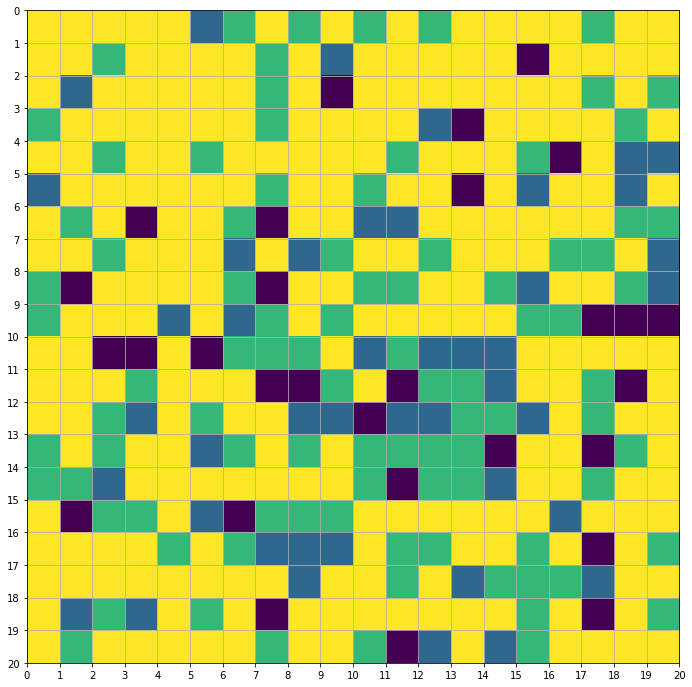

In [47]:
plt.figure(figsize = (12,12))
plt.yticks(np.arange(-0.5,20.5,1),np.arange(0,21,1))
plt.xticks(np.arange(-0.5,20.5,1),np.arange(0,21,1))
plt.grid(True)
plt.imshow(nodeTypeMatrix)
plt.savefig('./DataSave/nodeTypePicture.png')

In [31]:
with open('./DataSave/nodeTypeMatrix.pkl','wb') as fw:
    pickle.dump(nodeTypeMatrix,fw)

In [32]:
with open('./DataSave/nodeTypeList.pkl','wb') as fw:
    pickle.dump(nodeTypeList,fw)

#### 确定商家位置与订单顾客位置

In [ ]:
# 一天大概3万单，生成一个月的订单约100万。
# 对于每个订单，需要考虑两个问题，它产生在哪里，它又被送到了哪里
# 对于每个区域的订单，如果派单范围内没有人接收，它将被取消，如果范围内有人，那它一定要被派出去。
# 骑手被派到居民区或郊区如果没有单会自动形成一条去CBD或商业区的路，去最近的CBD或者商业区。

In [ ]:
# 订单：CBD区 45% 商业区 40% 居民区 10%  郊区：5%
# 送达：CBD区 30% 商业区 10%  居民区：50% 郊区：10%

In [ ]:
nodeTypeMatrix = open('./DataSave/nodeTypeMatrix.pkl','rb')
nodeTypeMatrix = pickle.load(nodeTypeMatrix)

In [ ]:
nodeTypeList = open('./DataSave/nodeTypeList.pkl','rb')
nodeTypeList = pickle.load(nodeTypeList)

In [ ]:
# 用概率来解决问题
# 每一个订单产生，它的商家在哪里，它的顾客又在哪里，这两者离多远？
# 如何确定订单产生的商家？40% 40% 15% 5% 产生概率，然后在内部进行随机平均产生
# 如何确定订单配送的位置？35% 10% 50% 5% 但距离会对订单配送位置产生影响，距离<5 45%  5<x<10  45%   >10 10%
# 所以需要给每一个node记录，记录node距离它的四种类型的[]

In [ ]:
nodeTypeMatrix = np.array(nodeTypeMatrix)

In [ ]:
# 3 郊区  2 居民区  1 消费区  0 CBD

In [ ]:
nodeTypeMatrix

In [ ]:
class Node:
    def __init__(self,num,x,y):
        self.nodeType = num
        self.nodeNum = y + 10 * x
        self.nodeCoord = (x,y)
        self.fiveNode= []
        self.tenNode = []
        self.moreTenNode = []
    
    def nodePrint(self):
        print('结点种类:'+ str(self.nodeType))
        print('结点编号:' + str(self.nodeNum))
        print('结点坐标:' + str(self.nodeCoord))

In [ ]:
nodeList = []
for i in range(20):
    for j in range(20):
        node = Node(nodeTypeMatrix[i,j],i,j)
        nodeList.append(node)
nodeMatrix = np.array(nodeList).reshape(20,20)

In [ ]:
# 距离计算函数

In [34]:
# 订单：CBD区 45% 商业区 40% 居民区 10%  郊区：5%
# 送达：CBD区 30% 商业区 10%  居民区：50% 郊区：10%

In [42]:
nodeTypeMatrix = open('./DataSave/nodeTypeMatrix.pkl','rb')
nodeTypeMatrix = pickle.load(nodeTypeMatrix)

In [43]:
nodeTypeList = open('./DataSave/nodeTypeList.pkl','rb')
nodeTypeList = pickle.load(nodeTypeList)

In [37]:
# 用概率来解决问题
# 每一个订单产生，它的商家在哪里，它的顾客又在哪里，这两者离多远？
# 如何确定订单产生的商家？40% 40% 15% 5% 产生概率，然后在内部进行随机平均产生
# 如何确定订单配送的位置？35% 10% 50% 5% 但距离会对订单配送位置产生影响，距离<5 45%  5<x<10  45%   >10 10%
# 所以需要给每一个node记录，记录node距离它的四种类型的[]

In [45]:
nodeTypeMatrix = np.array(nodeTypeMatrix)

In [ ]:
# 3 郊区  2 居民区  1 消费区  0 CBD

In [67]:
nodeTypeMatrix

array([[3, 3, 3, 3, 3, 1, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3],
       [3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3],
       [3, 1, 3, 3, 3, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2],
       [2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 2, 3],
       [3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 0, 3, 1, 1],
       [1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 0, 3, 1, 3, 3, 1, 3],
       [3, 2, 3, 0, 3, 3, 2, 0, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 2, 2],
       [3, 3, 2, 3, 3, 3, 1, 3, 1, 2, 3, 3, 2, 3, 3, 3, 2, 2, 3, 1],
       [2, 0, 3, 3, 3, 3, 2, 0, 3, 3, 2, 2, 3, 3, 2, 1, 3, 3, 2, 1],
       [2, 3, 3, 3, 1, 3, 1, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 0, 0, 0],
       [3, 3, 0, 0, 3, 0, 2, 2, 2, 3, 1, 2, 1, 1, 1, 3, 3, 3, 3, 3],
       [3, 3, 3, 2, 3, 3, 3, 0, 0, 2, 3, 0, 2, 2, 1, 3, 3, 2, 0, 3],
       [3, 3, 2, 1, 3, 2, 3, 3, 1, 1, 0, 1, 1, 2, 2, 1, 3, 2, 3, 3],
       [2, 3, 2, 3, 3, 1, 2, 3, 2, 3, 2, 2, 2, 2, 0, 3, 3, 0, 2, 3],
       [2, 2, 1, 3, 3, 3, 3, 3, 3,

In [68]:
class Node:
    def __init__(self,num,x,y):
        self.nodeType = num
        self.nodeNum = y + 10 * x
        self.nodeCoord = (x,y)
        self.fiveNode= []
        self.tenNode = []
        self.moreTenNode = []
    
    def nodePrint(self):
        print('结点种类:'+ str(self.nodeType))
        print('结点编号:' + str(self.nodeNum))
        print('结点坐标:' + str(self.nodeCoord))

In [69]:
nodeList = []
for i in range(20):
    for j in range(20):
        node = Node(nodeTypeMatrix[i,j],i,j)
        nodeList.append(node)
nodeMatrix = np.array(nodeList).reshape(20,20)

In [ ]:
# 距离计算函数